In [1]:
import pandas as pd
import numpy as np

from PIL import Image, ImageStat
import math
from tqdm import tqdm
import time, cv2

import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
from matplotlib import offsetbox
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA



# Set your path(s)...!!!

In [2]:
csv_full = r"C:\Users\tyle_\DataScientest\MushPy\reduced_dataset_5_families_Copie.csv"

folder_data = r'C:\Users\tyle_\DataScientest\MushPy\images\2nd try\images_mushroom\\'

### Load csv_full

In [3]:
df = pd.read_csv(csv_full)


folderpath = str(r'C:\Users\tyle_\DataScientest\MushPy\images\2nd try\images_mushroom\\')
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

df = df.sample(n=len(df))   #  if you take a sample higher than 1000, some cells will be very VERY long to run

df.head()

image_id                                      image_url  \
3642     132468  http://mushroomobserver.org/images/320/132468   
3010     108158  http://mushroomobserver.org/images/320/108158   
1885      64150   http://mushroomobserver.org/images/320/64150   
2480      87860   http://mushroomobserver.org/images/320/87860   
15462    621872  http://mushroomobserver.org/images/320/621872   

                family                                           filepath  \
3642   Fomitopsidaceae  C:\Users\tyle_\DataScientest\MushPy\images\2nd...   
3010   Fomitopsidaceae  C:\Users\tyle_\DataScientest\MushPy\images\2nd...   
1885     Omphalotaceae  C:\Users\tyle_\DataScientest\MushPy\images\2nd...   
2480     Omphalotaceae  C:\Users\tyle_\DataScientest\MushPy\images\2nd...   
15462  Fomitopsidaceae  C:\Users\tyle_\DataScientest\MushPy\images\2nd...   

       label  
3642       2  
3010       2  
1885       1  
2480       1  
15462      2

### Check the first picture in the dataframe

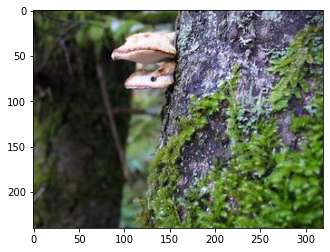

In [4]:
img = Image.open(df['filepath'].iloc[0]) # load the picture
aimg = np.asarray(img)                   # transform the picture in an array

plt.imshow(aimg);                        # show the picture

In [5]:
df_label_0 = df[df['label']==0]
df_label_1 = df[df['label']==1]
df_label_2 = df[df['label']==2]
df_label_3 = df[df['label']==3]
df_label_4 = df[df['label']==4]

# df_label_0

### Split data :

In [6]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_label_0['filepath'], df_label_0['label'], test_size=0.2, random_state=1234)

In [7]:
size = 128         # set the size of the pictures here

### Load X_test images :

In [8]:
# some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study

imgBW = []         # create a list for images black & white
y_testBW = []      # create a list for y_test with images black & white
y_test = []        # create a list for y_test with images in colors
X_test = []        # create a list for X_test with images in colors

i=0                # counter initialization

for filepath in tqdm(X_test_path):       # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)           # load picture
    img_test_RGB = img.getcolors()       # => check if there are colors or not on the picture
    
    if img_test_RGB != None:             # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_testBW.append(df_label_0['label'].iloc[i])
        i += 1
        
    else:                                # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_test.append(D1_imggray)
        y_test.append(df_label_0['label'].iloc[i])
        i += 1

X_test = np.asarray(X_test)              # transform X_test from list to np.array
y_test = np.asarray(y_test)              # transform y_test from list to np.array

100%|██████████| 783/783 [00:01<00:00, 392.43it/s]


### Load X_train images :

In [9]:
# Same thing than previously, some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study


imgBW = []         # create a list for images black & white
y_trainBW = []      # create a list for y_train with images black & white
y_train = []        # create a list for y_train with images in colors
X_train = []        # create a list for X_train with images in colors

i=0                # counter initialization

for filepath in tqdm(X_train_path):    # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)         # load picture
    img_test_RGB = img.getcolors()     # => check if there are colors or not on the picture
    
    if img_test_RGB != None:           # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_trainBW.append(df_label_0['label'].iloc[i])
        i += 1
    else:                              # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_train.append(D1_imggray)
        y_train.append(df_label_0['label'].iloc[i])
        i += 1

#X_train = np.concatenate(X_train, axis=0)

X_train = np.asarray(X_train)          # transform X_train from list to np.array
y_train = np.asarray(y_train)          # transform y_train from list to np.array

100%|██████████| 3131/3131 [00:07<00:00, 412.63it/s]


### Check the first picture from X_train

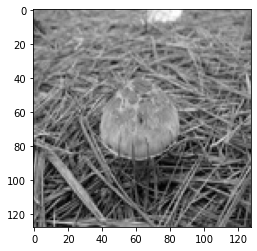

In [10]:
plt.imshow(X_train[0].reshape([size,size]), cmap='gray');

### Let's have a look about few pictures of df_label_0

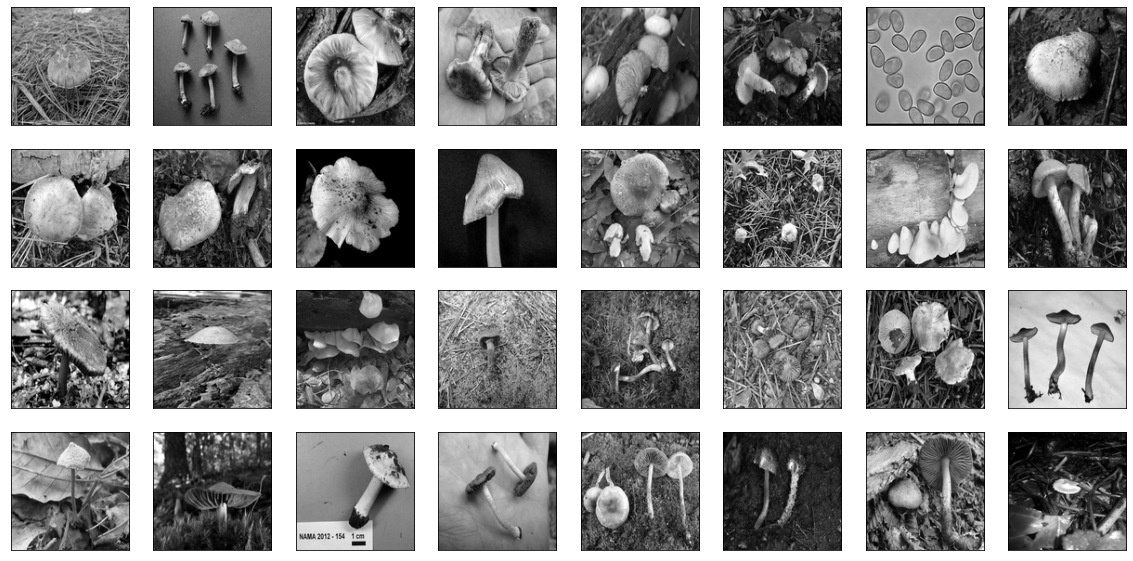

In [11]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(size,size), cmap='gray')

# df_label_1

### Split data :

In [12]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_label_1['filepath'], df_label_1['label'], test_size=0.2, random_state=1234)

size = 128         # set the size of the pictures here

# LOAD IMAGES X_test

# some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study

imgBW = []         # create a list for images black & white
y_testBW = []      # create a list for y_test with images black & white
y_test = []        # create a list for y_test with images in colors
X_test = []        # create a list for X_test with images in colors

i=0                # counter initialization

for filepath in tqdm(X_test_path):       # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)           # load picture
    img_test_RGB = img.getcolors()       # => check if there are colors or not on the picture
    
    if img_test_RGB != None:             # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_testBW.append(df_label_1['label'].iloc[i])
        i += 1
        
    else:                                # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_test.append(D1_imggray)
        y_test.append(df_label_1['label'].iloc[i])
        i += 1

X_test = np.asarray(X_test)              # transform X_test from list to np.array
y_test = np.asarray(y_test)              # transform y_test from list to np.array


# LOAD IMAGES X_train


# Same thing than previously, some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study


imgBW = []         # create a list for images black & white
y_trainBW = []      # create a list for y_train with images black & white
y_train = []        # create a list for y_train with images in colors
X_train = []        # create a list for X_train with images in colors

i=0                # counter initialization

for filepath in tqdm(X_train_path):    # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)         # load picture
    img_test_RGB = img.getcolors()     # => check if there are colors or not on the picture
    
    if img_test_RGB != None:           # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_trainBW.append(df_label_1['label'].iloc[i])
        i += 1
    else:                              # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_train.append(D1_imggray)
        y_train.append(df_label_1['label'].iloc[i])
        i += 1

#X_train = np.concatenate(X_train, axis=0)

X_train = np.asarray(X_train)          # transform X_train from list to np.array
y_train = np.asarray(y_train)          # transform y_train from list to np.array

100%|██████████| 3052/3052 [00:07<00:00, 387.71it/s]


### Let's have a look about few pictures of df_label_1

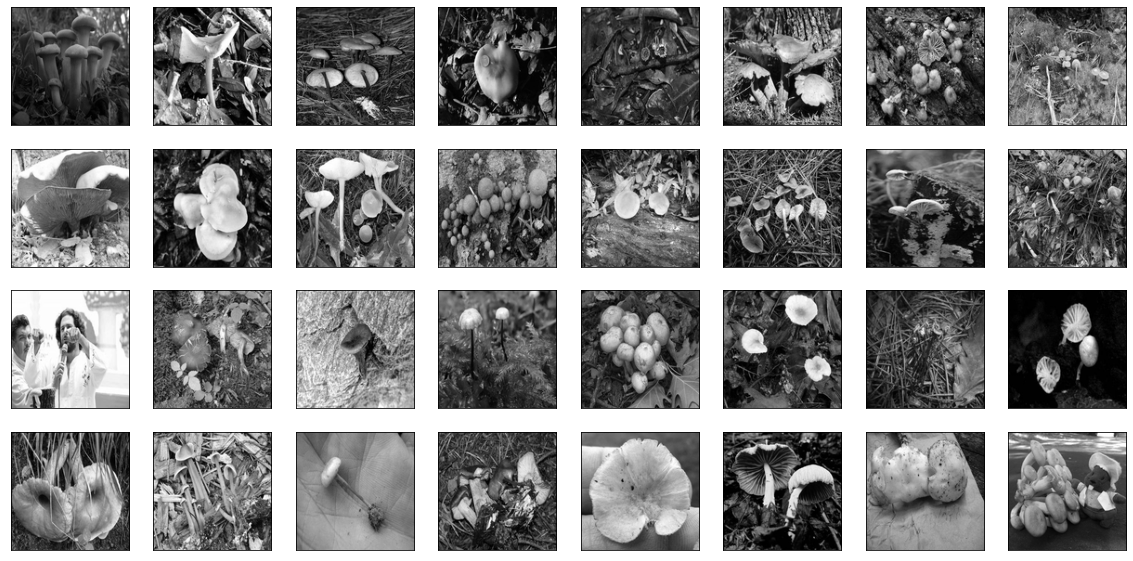

In [13]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(size,size), cmap='gray')

# df_label_2

### Split data :

In [14]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_label_2['filepath'], df_label_2['label'], test_size=0.2, random_state=1234)

size = 128         # set the size of the pictures here

# LOAD IMAGES X_test

# some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study

imgBW = []         # create a list for images black & white
y_testBW = []      # create a list for y_test with images black & white
y_test = []        # create a list for y_test with images in colors
X_test = []        # create a list for X_test with images in colors

i=0                # counter initialization

for filepath in tqdm(X_test_path):       # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)           # load picture
    img_test_RGB = img.getcolors()       # => check if there are colors or not on the picture
    
    if img_test_RGB != None:             # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_testBW.append(df_label_2['label'].iloc[i])
        i += 1
        
    else:                                # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_test.append(D1_imggray)
        y_test.append(df_label_2['label'].iloc[i])
        i += 1

X_test = np.asarray(X_test)              # transform X_test from list to np.array
y_test = np.asarray(y_test)              # transform y_test from list to np.array


# LOAD IMAGES X_train


# Same thing than previously, some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study


imgBW = []         # create a list for images black & white
y_trainBW = []      # create a list for y_train with images black & white
y_train = []        # create a list for y_train with images in colors
X_train = []        # create a list for X_train with images in colors

i=0                # counter initialization

for filepath in tqdm(X_train_path):    # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)         # load picture
    img_test_RGB = img.getcolors()     # => check if there are colors or not on the picture
    
    if img_test_RGB != None:           # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_trainBW.append(df_label_2['label'].iloc[i])
        i += 1
    else:                              # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_train.append(D1_imggray)
        y_train.append(df_label_2['label'].iloc[i])
        i += 1

#X_train = np.concatenate(X_train, axis=0)

X_train = np.asarray(X_train)          # transform X_train from list to np.array
y_train = np.asarray(y_train)          # transform y_train from list to np.array

100%|██████████| 2557/2557 [00:06<00:00, 380.96it/s]


### Let's have a look about few pictures of df_label_2

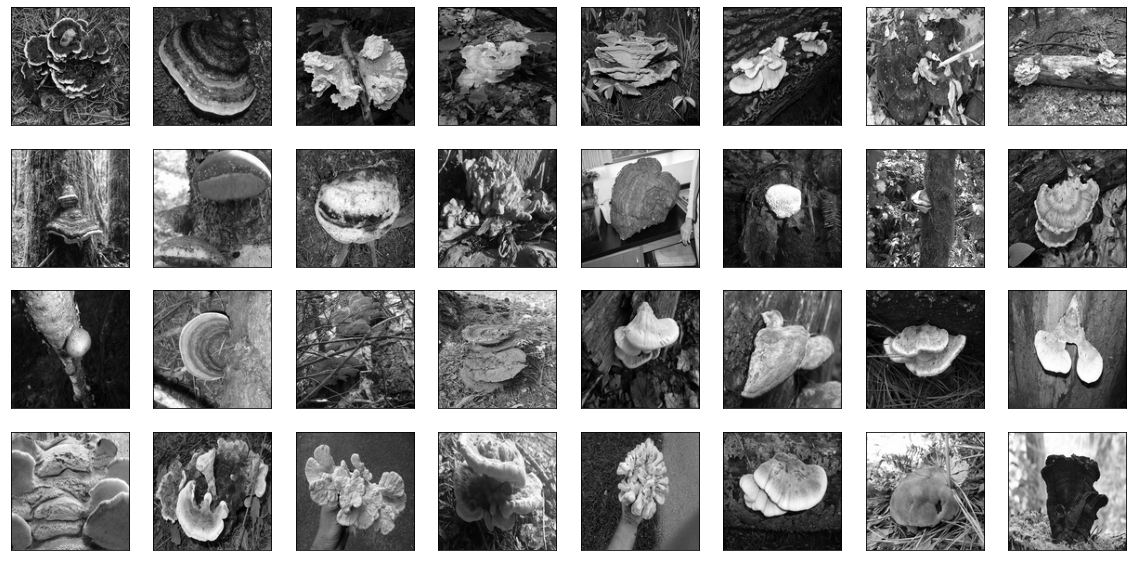

In [15]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(size,size), cmap='gray')

# df_label_3

### Split data :

In [16]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_label_3['filepath'], df_label_3['label'], test_size=0.2, random_state=1234)

size = 128         # set the size of the pictures here

# LOAD IMAGES X_test

# some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study

imgBW = []         # create a list for images black & white
y_testBW = []      # create a list for y_test with images black & white
y_test = []        # create a list for y_test with images in colors
X_test = []        # create a list for X_test with images in colors

i=0                # counter initialization

for filepath in tqdm(X_test_path):       # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)           # load picture
    img_test_RGB = img.getcolors()       # => check if there are colors or not on the picture
    
    if img_test_RGB != None:             # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_testBW.append(df_label_3['label'].iloc[i])
        i += 1
        
    else:                                # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_test.append(D1_imggray)
        y_test.append(df_label_3['label'].iloc[i])
        i += 1

X_test = np.asarray(X_test)              # transform X_test from list to np.array
y_test = np.asarray(y_test)              # transform y_test from list to np.array


# LOAD IMAGES X_train


# Same thing than previously, some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study


imgBW = []         # create a list for images black & white
y_trainBW = []      # create a list for y_train with images black & white
y_train = []        # create a list for y_train with images in colors
X_train = []        # create a list for X_train with images in colors

i=0                # counter initialization

for filepath in tqdm(X_train_path):    # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)         # load picture
    img_test_RGB = img.getcolors()     # => check if there are colors or not on the picture
    
    if img_test_RGB != None:           # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_trainBW.append(df_label_3['label'].iloc[i])
        i += 1
    else:                              # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_train.append(D1_imggray)
        y_train.append(df_label_3['label'].iloc[i])
        i += 1

#X_train = np.concatenate(X_train, axis=0)

X_train = np.asarray(X_train)          # transform X_train from list to np.array
y_train = np.asarray(y_train)          # transform y_train from list to np.array

100%|██████████| 2534/2534 [00:13<00:00, 181.68it/s]


### Let's have a look about few pictures of df_label_3

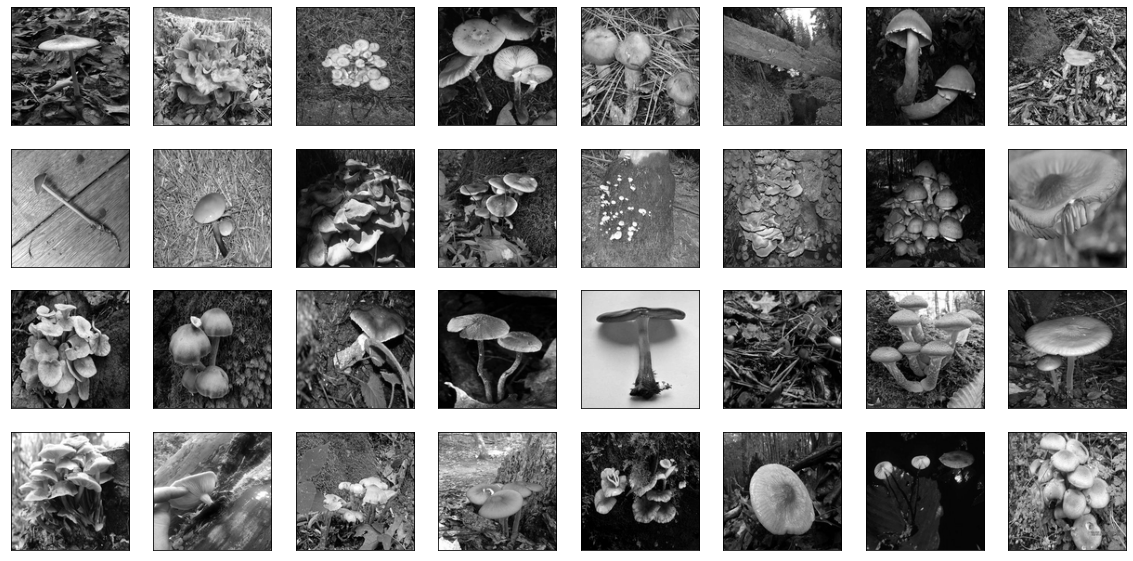

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(size,size), cmap='gray')

### Let's use **`Isomap`** to identify variance factors of the mushrooms.

The cell below can be very long to run if the dataset is higher than 1000 items in it

# df_label_4

### Split data :

In [18]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_label_4['filepath'], df_label_4['label'], test_size=0.2, random_state=1234)

size = 128         # set the size of the pictures here

# LOAD IMAGES X_test

# some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study

imgBW = []         # create a list for images black & white
y_testBW = []      # create a list for y_test with images black & white
y_test = []        # create a list for y_test with images in colors
X_test = []        # create a list for X_test with images in colors

i=0                # counter initialization

for filepath in tqdm(X_test_path):       # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)           # load picture
    img_test_RGB = img.getcolors()       # => check if there are colors or not on the picture
    
    if img_test_RGB != None:             # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_testBW.append(df_label_4['label'].iloc[i])
        i += 1
        
    else:                                # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_test.append(D1_imggray)
        y_test.append(df_label_4['label'].iloc[i])
        i += 1

X_test = np.asarray(X_test)              # transform X_test from list to np.array
y_test = np.asarray(y_test)              # transform y_test from list to np.array


# LOAD IMAGES X_train


# Same thing than previously, some images in the dataset were with different charateristics than the majority of the other ones
# I decided to separate them from the other ones as it was only drawings which were not part of our study


imgBW = []         # create a list for images black & white
y_trainBW = []      # create a list for y_train with images black & white
y_train = []        # create a list for y_train with images in colors
X_train = []        # create a list for X_train with images in colors

i=0                # counter initialization

for filepath in tqdm(X_train_path):    # this loop separate B&W images from the other ones and load our images + transform them by resizing and removing the colors from the pictures 
    
    img = Image.open(filepath)         # load picture
    img_test_RGB = img.getcolors()     # => check if there are colors or not on the picture
    
    if img_test_RGB != None:           # separate  B&W pictures & transform + add them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        imgBW.append(img)
        y_trainBW.append(df_label_4['label'].iloc[i])
        i += 1
    else:                              # transform & add pictures them in a list (only drawings out of our study)
        img = img.resize((size, size), Image.ANTIALIAS)
        aimg = np.asarray(img)
        R, G, B = aimg[:,:,0], aimg[:,:,1], aimg[:,:,2]
        imggray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        imggray_0, imggray_1 = imggray.shape
        D1_imggray = imggray.reshape([imggray_0*imggray_1])
        X_train.append(D1_imggray)
        y_train.append(df_label_4['label'].iloc[i])
        i += 1

#X_train = np.concatenate(X_train, axis=0)

X_train = np.asarray(X_train)          # transform X_train from list to np.array
y_train = np.asarray(y_train)          # transform y_train from list to np.array

100%|██████████| 2433/2433 [00:13<00:00, 179.25it/s]


### Let's have a look about few pictures of df_label_4

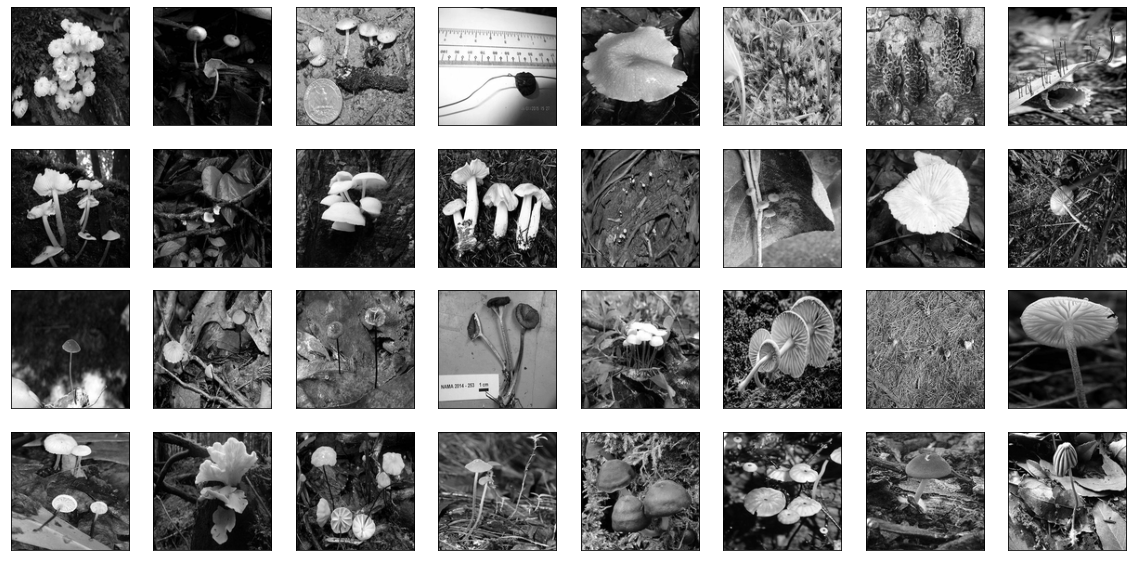

In [19]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]),figsize=(20,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(size,size), cmap='gray')